In [1]:
import requests
import numpy as np
import pandas as pd

import random
import json
import re

import datetime

fetch_oadoi = False
fetch_crossref = False
fetch_altmetric = False

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/cancer_news_stories.txt', sep='\t', header=None)
df.columns = ['created_at', 'moreover_url', 'url', 'title', 'snippet', 'altmetric_ids', 'dois', 'pmids']
for ids in ['altmetric_ids', 'dois', 'pmids']:
    df[ids] = df[ids].map(lambda x: ','.join(set(str(x).split(','))) if x == x else np.nan)
df.index.name = 'story_id'
df['created_at'] = pd.to_datetime(df.created_at)

df = df[~df.dois.isnull()]

In [3]:
df = df[df.created_at >= '2016-01-01']
df = df[df.created_at < '2017-01-01']
# df = df[df.has_cancer]
# del df['has_cancer']

df2 = pd.DataFrame(df.dois.str.split(',').tolist(), index=df.index).stack()
df2.name = 'doi'
df2.index = df2.index.droplevel(1)
df = df.join(df2)

In [197]:
def get_oaDOI(doi):
    global counter
    url = 'https://api.oadoi.org/%s' % doi
    headers = {'Content-Type': 'application/json', 
       'Accept': 'application/json'}
    
    counter = counter + 1
    if counter % 10 == 0:
        print(counter)
    response = None
    try: 
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.text
    except Exception as e:
        print(e)
        print(response)
        pass
    return False

In [198]:
# Stefanie 
# df2 = pd.read_csv('data/DOI_OAstatus.txt', sep='\t')
# df2.set_index('DOI', inplace=True)
# df2.head()

In [199]:
counter = 0

def get_altmetric(altmetric_id):
    global counter
    url = 'http://api.altmetric.com/v1/doi/%s' % altmetric_id
    headers = {'content-type': 'application/json'}
    response = requests.post(url, headers=headers)
    counter = counter + 1
    if counter % 50 == 0:
        print (counter)
    try: 
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            return False
    except: 
        return False    

In [200]:
counter = 0

def get_crossref(doi):
    global counter
    url = 'https://api.crossref.org/works/%s' % doi
    headers = {'content-type': 'application/json'}
    response = requests.post(url, headers=headers)
    counter = counter + 1
    if counter % 50 == 0:
        print (counter)
    try: 
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            return False
    except: 
        return False    

In [4]:
# Dates in dataset
print("since: ", df.created_at.min())
print("until: ", df.created_at.max())

since:  2016-01-01 00:00:00
until:  2016-12-31 19:03:32


In [5]:
# Number of stories and articles
print("stories: ", len(df))
print("articles: ", len(df.doi.unique()))

stories:  67236
articles:  11523


In [6]:
# average number of stories
df.groupby('doi').size().describe()

count    11523.000000
mean         5.834939
std         14.163605
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max        270.000000
dtype: float64

In [204]:
# oaDOIresponses = filter(lambda x: type(x) == dict, dois_df)
# print "Discarding %s DOIs because could not fech. That's %.2f of all DOIs" % (len(dois_df) - len(oaDOIresponses), ((len(dois_df) - len(oaDOIresponses))*100.0)/len(dois_df))
# oaDOI = pd.DataFrame.from_records(oaDOIresponses, index='doi')
# # print "Discarding %s DOIs because of errors. That's %.2f of all DOIs" % (len(oaDOI[~oaDOI.error.isnull()]), len(oaDOI[~oaDOI.error.isnull()]) * 100.0 / len(oaDOI))
# # oaDOI = oaDOI[oaDOI.error.isnull()]
# oaDOI.oa_color = oaDOI.oa_color.fillna('black')
# del oaDOI['url']

# df = df.merge(oaDOI, left_on='doi', right_index=True)


In [205]:
if fetch_oadoi: 
    oaDOI = df['doi'].to_frame()
    oaDOI['oaDOI_response'] = oaDOI.doi.map(get_oaDOI)

In [206]:
# OLD
# oaDOI = pd.read_csv('data/juan_rerun.csv')
# oaDOI.oa_color = oaDOI.oa_color.fillna('black')
# oaDOI.head()

,doi,oa_color,free_fulltext_url,evidence,content
0,10.1001/archderm.148.1.122,black,NaN,closed,"{""doi"": ""10.1001/archderm.148.1.122"", ""url"": ""..."
1,10.1001/archdermatol.2009.308,black,NaN,closed,"{""doi"": ""10.1001/archdermatol.2009.308"", ""url""..."
2,10.1001/archdermatol.2011.173,black,NaN,closed,"{""doi"": ""10.1001/archdermatol.2011.173"", ""url""..."
3,10.1001/archgenpsychiatry.2010.116,black,NaN,closed,"{""doi"": ""10.1001/archgenpsychiatry.2010.116"", ..."
4,10.1001/archinte.161.2.277,black,NaN,closed,"{""doi"": ""10.1001/archinte.161.2.277"", ""url"": ""..."


In [7]:
# NEW
oaDOI = pd.read_csv('data/oaDOI_20170615.csv')
del oaDOI['story_id']
oaDOI['json'] = oaDOI.oaDOI_response.map(lambda x: json.loads(x) if len(x) > 5 else False)

def get_oadoi_field(x, field):
    try: 
        return x['results'][0][field]
    except:
        return None
oaDOI['oa_color'] = oaDOI.json.map(lambda x: get_oadoi_field(x, 'oa_color'))
oaDOI['oa_color'].fillna('black', inplace=True)
oaDOI['free_fulltext_url'] = oaDOI.json.map(lambda x: get_oadoi_field(x, 'free_fulltext_url'))
oaDOI['evidence'] = oaDOI.json.map(lambda x: get_oadoi_field(x, 'evidence'))

del oaDOI['oaDOI_response']
del oaDOI['json']

In [6]:
oaDOI.groupby('oa_color').size()

oa_color
black    6997
blue      286
gold     1314
green    2926
dtype: int64

In [5]:
oaDOI[oaDOI.oa_color == 'black'].doi.to_csv('data/cancer_dois_in_news_closed.csv')

In [8]:
oaDOI.groupby('oa_color').size().divide(.01*len(oaDOI))

oa_color
black    60.722034
blue      2.481993
gold     11.403280
green    25.392693
dtype: float64

In [9]:
df = df.merge(oaDOI, left_on='doi', right_on='doi')
df.set_index('doi', inplace=True)

In [10]:
df.to_csv('data/for_lauren.csv')

In [211]:
# WARNING: fetches from CrossRef and Altmetric
# oaDOI['crossref'] = oaDOI.index.map(get_crossref)
# oaDOI['crossref'] = oaDOI.crossref.map(lambda r: r['message'] if r else None)
# oaDOI['crossref_json'] = oaDOI.crossref.map(json.dumps)
# oaDOI['altmetric'] = oaDOI.index.map(get_altmetric)
# oaDOI['altmetric-published-date'] = oaDOI.altmetric.map(lambda x: x['published_on'] if x and 'published_on' in x.keys() else None)
# oaDOI['altmetric-published-date'] = pd.to_datetime(oaDOI['altmetric-published-date'].multiply(1e9))
# oaDOI['altmetric_json'] = oaDOI.altmetric.map(json.dumps)
# oaDOI.to_csv('data/oaDOI_withcrossref_and_altmetric.csv')

In [212]:
# oaDOI.to_csv('data/oaDOI_withcrossref_and_altmetric.csv', encoding='utf8')

In [27]:
crossref_altmetric = pd.read_csv('data/oaDOI_withcrossref_and_altmetric.csv')
crossref_altmetric = crossref_altmetric.set_index('doi')
crossref_altmetric = crossref_altmetric[['crossref_json', 'altmetric-published-date']]

In [28]:
df = df.merge(crossref_altmetric, left_index=True, right_index=True)
df.to_csv('data/oaDOI_withcrossref_and_altmetric_rerun_20170615.csv', encoding='utf8')

In [ ]:
del df['crossref_json']
del df['dois']
del df['pmids']
del df['altmetric_ids']
df.to_excel('data/oaDOI_withcrossref_and_altmetric_rerun_20170617_small.xlsx')

In [ ]:
oaDOI = df

In [ ]:
def get_date(c):
    c = json.loads(c)
    if not c:
        return False
    try: 
        if 'issued' in c:
            d = c['issued']
    except:
        print(type(c))
        raise
#     if 'published-online' in c:
#         d = c['published-online']
#     elif  'published-print' in c: 
#         d = c['published-print']
#     else:
#         d = False # c['created']
    
    try: 
        d = d['date-parts'][0]
        if len(d) == 1:
            return False
        if len(d) == 2:
            return datetime.datetime(d[0], d[1], 1)
    
        return datetime.datetime(d[0], d[1], d[2])
    except:
        return False
    

oaDOI['published-date'] = oaDOI.crossref_json.map(get_date)
len(oaDOI[oaDOI['published-date'].notnull()])*100./len(oaDOI)

In [218]:
def get_min_date(x):
    if x['published-date'] and x['altmetric-published-date']:
        return min(x['published-date'], x['altmetric-published-date'])
    
    if x['published-date']:
        return x['published-date']
    
    if x['altmetric-published-date']:
        return x['altmetric-published-date']

# change False to None
oaDOI['published-date'] = oaDOI['published-date'].map(lambda x: x if x and x != 'False' else None)
oaDOI['altmetric-published-date'] = oaDOI['altmetric-published-date'].map(lambda x: x if x and x != 'False' else None)

oaDOI['published-date'] = pd.to_datetime(oaDOI['published-date'])
oaDOI['altmetric-published-date'] = pd.to_datetime(oaDOI['altmetric-published-date'])

oaDOI['earliest-pub-date'] = oaDOI.apply(get_min_date, axis=1)

In [219]:
# try: 
#     del df['earliest-pub-date']
# except:
#     pass
# df = df.merge(oaDOI[['earliest-pub-date']], left_index=True, right_index=True)
df['days_old'] = df.apply(lambda row: row['created_at'] - row['earliest-pub-date'] if row['earliest-pub-date'] else None, axis=1)
print("Dropping %s with no dates (%.1f%%)" % (len(df[df.days_old.isnull()]), len(df[df.days_old.isnull()])*100/len(df)))
df = df[df.days_old.notnull()]

Dropping 1793 with no dates (2.7%)


In [220]:
df[(df.days_old.map(lambda x: x.days) >= -30)].days_old.describe()

count                        65093
mean      340 days 13:18:50.108905
std      1156 days 08:06:15.190200
min             -29 days +04:00:00
25%                1 days 15:49:02
50%               14 days 20:05:16
75%               96 days 11:00:25
max            42878 days 20:37:08
Name: days_old, dtype: object

In [221]:
df[(df.days_old.map(lambda x: x.days) >= -30)  & (df.days_old.map(lambda x: x.days) <= 365)].days_old.describe()

count                      55325
mean     37 days 01:17:39.871938
std      68 days 01:01:11.798595
min           -29 days +04:00:00
25%              1 days 11:06:00
50%              7 days 21:21:56
75%             36 days 08:13:00
max            365 days 20:37:28
Name: days_old, dtype: object

In [222]:
tableau20_rgb = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
tableau20 = {}
for i, (r,g,b) in enumerate(tableau20_rgb):  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

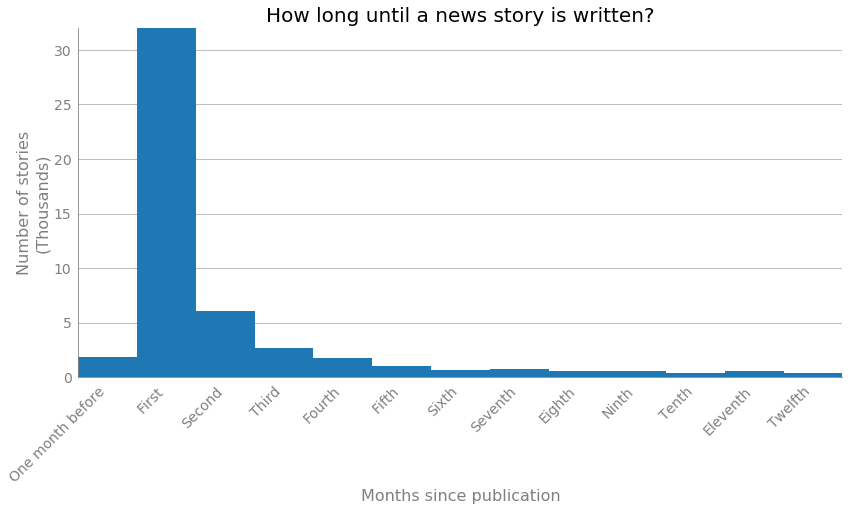

In [223]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')


plt.rcParams['figure.figsize'] = (12.0, 8.0)
fig, ax = plt.subplots()
df.days_old.map(lambda x: x.days).hist(bins=range(-30, 390, 30), color=tableau20[0], linewidth=0, ax=ax)
ax.set_xlim([-30, 360])
ax.set_ylim([0, 32000])
ax.xaxis.grid(False)

ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_color('grey')
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_color('grey')  

ax.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.yticks(range(0,32500, 5000), [str(x) for x in range(0,32, 5)], color='grey', fontsize=14)  
ax.set_ylabel('Number of stories\n(Thousands)', color='grey', fontsize=16)

ticks = plt.xticks([-15] + list(range(15, 365, 30)), ['One month before'] + ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh', 'Twelfth'], rotation=45, color='grey', ha='right', fontsize=14)
ax.set_xlabel('Months since publication', color='grey', fontsize=16)

ax.set_title('How long until a news story is written?', fontsize=20)
plt.tight_layout(rect=[0, .1, 1, 1])

plt.savefig('data/months_since_publication_v2.png')

In [191]:
df['bins'] = pd.cut(df.days_old.map(lambda x: x.days), range(-30, 365, 30))

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [192]:
df.groupby('bins').size()

bins
(-30, 0]      10713
(0, 30]       29329
(30, 60]       5821
(60, 90]       2590
(90, 120]      1789
(120, 150]      993
(150, 180]      777
(180, 210]      687
(210, 240]      601
(240, 270]      566
(270, 300]      427
(300, 330]      565
(330, 360]      390
dtype: int64

In [193]:
oaDOI['funder'] = oaDOI.crossref.map(lambda r: r['funder'] if r and 'funder' in r else None)

funders = oaDOI[~oaDOI.funder.isnull()].funder.map(lambda x: [f['name'] if 'name' in f else None for f in x])
funders[funders.map(lambda f: 'National Institute' in f)]

AttributeError: 'DataFrame' object has no attribute 'crossref'

In [ ]:
df = df.reset_index()

In [ ]:
# number of stories by different limits
df_lims = {}
for lim in [0, 10, 25, 50]:
    df_lims[lim] = df.groupby('doi').filter(lambda x: len(x) >= lim)
    print "At least %s: %s" % (lim, len(df_lims[lim].doi.unique()))

In [ ]:
df = df.reset_index()

In [ ]:
df = df.merge(oaDOI, left_on='doi', right_index=True)

In [ ]:
oa_mentions = {}
for lim in range(0, 60, 10):
    df2 = df.groupby('doi').filter(lambda x: len(x) >= lim)
    oa_color = df2[['doi', 'oa_color']].drop_duplicates().set_index('doi')
    oa_color = oa_color.groupby('oa_color').size().multiply(100.0).divide(len(oa_color))
    oa_mentions[lim] = oa_color['gold']
    print "At least %s: %s articles of which %.2f%% are OA" % (lim, len(df2.doi.unique()), oa_mentions[lim])
#     print oa_color.to_string()
#     print

In [ ]:
df[['doi', 'oa_color']].drop_duplicates().set_index('doi').groupby('oa_color').size().divide(.01*11044).map(lambda x: "%.2f%%" % x)

In [ ]:
oa_color = df[['doi', 'oa_color']].drop_duplicates().set_index('doi')

In [ ]:
df[['doi', 'oa_color']].head()

In [ ]:
print len(df[['doi', 'oa_color']])
print len(df[['doi', 'oa_color']].drop_duplicates())
print len(oa_color)
print oa_color.groupby('oa_color').size().divide(len(oa_color)*.01)

In [ ]:
df[['doi', 'oa_color', 'evidence']].drop_duplicates().groupby(['oa_color', 'evidence']).size().sort_index()

In [ ]:
num_mentions = df.groupby('doi').size()
num_mentions.name = 'num_mentions'

In [ ]:
oa_color = df.set_index('doi').join(num_mentions).reset_index()[['doi', 'oa_color', 'num_mentions']].drop_duplicates().set_index('doi')
oa_color = oa_color[~oa_color.num_mentions.isnull()]
oa_color['doi_as_link'] = oa_color.index.map(lambda doi: "http://doi.org/%s" % doi)

In [ ]:
oa_color.sort_values('num_mentions', ascending=False).to_csv('data/news_story_dois_oastatus.csv')

In [ ]:
gb = oa_color.groupby(['num_mentions', 'oa_color'])
# gb.size().unstack().apply(lambda row: row['gold']*100.0/sum(row), axis=1)

In [ ]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0)
df3 = gb.size().unstack().fillna(0).apply(lambda row: row['gold']*100.0/sum(row), axis=1)
area = np.pi * (10+log(oa_color.groupby('num_mentions').size().divide(len(oa_color))))**2
fig, ax = plt.subplots()
plt.scatter(df3.index, df3, s=area)
ax.set_xlim([0,300])
ax.set_ylim([-.5, 105])
ax.set_xlabel('exactly x mentions')
ax.set_ylabel('% OA')

In [ ]:
fig, ax = plt.subplots()

df3 = gb.size().unstack().fillna(0).sort_index(ascending=False).cumsum().sort_index()

# ax = df3.sum(axis=1).plot.bar()
area = np.pi*log(df3.sum(axis=1))**2

# errors = df3.apply(lambda row: row['gold']/float(sum(row)), axis=1).map(lambda x: x*(1-x)).divide(df3.sum(axis=1)).map(np.sqrt).multiply(100)
df3.apply(lambda row: row['gold']*100.0/sum(row), axis=1).reset_index().plot.scatter(x='num_mentions', y=0, title="% OA by minimum number of news mentions", s=30, xlim=[0,150], alpha=.5, ax=ax)

ax.set_xlim([0, 165])
# ax.set_ylim([0, 32000])
ax.xaxis.grid(False)

ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_color('grey')
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_color('grey')  

ax.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on") 



# ax.set_xlim([0,df3.index.max()+5])

# ax2 = ax.twinx()
# # area = np.pi * (15*())**2

ax.set_ylim([0,105])
ax.set_xlabel('at least x mentions')
ax.set_ylabel('% OA')

plt.savefig('data/oa_by_min_mentions.png')

# # ax2 = plt.scatter(df3.index, , s=30)




In [ ]:
# Number of Gold OA for articles with at least 50 mentions
df3 = oa_color[oa_color.num_mentions >= 50].groupby(['num_mentions', 'oa_color']).size().unstack().fillna(0).sort_index(ascending=False).cumsum().sort_index()
print "%.2f%% gold OA" % (df3['gold'].sum() * 100.0 / df3.sum(axis=1).sum())
print "%.2f%% green" % (df3['green'].sum() * 100.0 / df3.sum(axis=1).sum())

In [ ]:
from urlparse import urlparse
df['url'] = df.apply(lambda row: row['url'] if row['url'] == row['url'] else row['moreover_url'], axis=1)
df['domain'] = df.url.map(lambda url: re.sub('^www\.', '', urlparse(url).netloc) if url == url else np.nan)

In [ ]:
df.groupby('domain').size().describe()['75%']

In [ ]:
# Top 25% of domain names
df.groupby('domain').filter(lambda x: len(x) > 100).groupby('domain').size().sort_values(ascending=False)

In [ ]:
domains = ['nytimes.com', 'washingtonpost.com', 'slate.com', 'huffingtonpost.com', 'theatlantic.com', 'theguardian.com', 'salon.com', 'latimes.com', 'foxnews.com', 'npr.org']

for d in domains: 
    domain_df = df[df.domain.str.contains(d)]
    print "Domain: ", d, [x for x in domain_df.domain.unique()]
    print "%s articles" % len(domain_df)
    print "%.2f%% OA" % domain_df.groupby('oa_color').size().multiply(100.0).divide(len(domain_df))['gold']
    print
del domain_df

In [ ]:
sample_10p.groupby('classification').size().multiply(100.0).div(len(sample_10p)).plot.bar()

In [ ]:
sample_10p.groupby('dissmin_classification').size().multiply(100.0).div(len(sample_10p))

In [ ]:
sample_10p.groupby('classification').size().multiply(100.0).div(len(sample_10p))

In [ ]:
first_story = df.sort_values(by='posted_on:conv').groupby('citation:doi').first()

In [ ]:
df3 = oa_color[oa_color.num_mentions >= 100].groupby(['num_mentions', 'oa_color']).size().unstack().fillna(0).sort_index(ascending=False).cumsum().sort_index()

In [ ]:
df3.head()

In [ ]:
df3.apply(lambda row: row['gold']/float(sum(row)), axis=1).map(lambda x: x*(1-x)).divide(df3.sum(axis=1)).map(np.sqrt).multiply(100)

In [ ]:
oa_color = df.set_index('doi').join(num_mentions).reset_index()[['doi', 'oa_color', 'num_mentions']].drop_duplicates().set_index('doi')
oa_color = oa_color[~oa_color.num_mentions.isnull()]

oa_color.to_csv('data/top50news_oadoi_status.csv', sep="\t")

In [ ]:

b

In [ ]:
gb = first_story.join(sample_10p.set_index('doi'))
gb['year'] = gb['posted_on:conv'].map(lambda x: x.year)
gb = gb[gb.year > 2011]
gb = gb[gb.classification.notnull()].groupby(['year', 'classification']).size()

In [ ]:
tmp = gb.multiply(100.0).divide(gb.groupby(level=0).sum()).unstack()

In [ ]:
tmp.index = [2012,2013,2014]

In [ ]:
response = get_crossref('http://api.crossref.org/works/10.1016/j.neuroscience.2015.10.035')

In [ ]:
# for stef
len(df.index.tolist())

In [ ]:
responses = []
for i in range(0, 40, 25):    
    dois = df.iloc[i:i+25].apply(lambda x: ''.join(x.index)).tolist()
    responses += get_oaDOIs(dois)


In [ ]:
len(responses)

In [ ]:
oaDOI = pd.DataFrame.from_records(responses, index='doi')
print "Discarding %s DOIs because of errors. That's %.2f of all DOIs" % (len(oaDOI[~oaDOI.error.isnull()]), len(oaDOI[~oaDOI.error.isnull()]) * 100.0 / len(oaDOI))
oaDOI = oaDOI[oaDOI.error.isnull()]
oaDOI.oa_color = oaDOI.oa_color.fillna('black')

df2 = df.join(oaDOI)

In [ ]:
df = pd.read_csv('data/oaDOI_withcrossref_and_altmetric.csv')

In [ ]:
df_new = df[[u'doi', u'doi_resolver', u'license', u'free_fulltext_url', u'is_free_to_read', u'is_boai_license', u'is_subscription_journal', u'oa_color', u'evidence', u'_title']].drop_duplicates().set_index('doi')
print len(df_new)
df_new.to_csv('data/new_oaDOI_responses.csv', encoding='utf8')

In [ ]:
df_old = pd.read_csv('data/oaDOI_withcrossref.csv', encoding='utf8')
df_old.set_index('doi', inplace=True)
df_old.groupby('oa_color').size().divide(len(df_old)*.01)

In [ ]:
df_new.merge(df_old, how='left', left_index=True, right_index=True, suffixes=('_new', '_old')).to_csv('data/oaDOIcomparison.csv', encoding='utf8')

In [ ]:
cp = df_new.merge(df_old, how='left', left_index=True, right_index=True, suffixes=('_new', '_old'))

In [ ]:
cp[cp['oa_color_old'] != cp['oa_color_new']][['oa_color_new', 'evidence_new', 'oa_color_old', 'evidence_old']]

In [ ]:
df_compare = pd.read_csv('data/oaDOIcomparison.csv', encoding='utf8')

In [ ]:
df_compare.groupby('oa_color_old').size()

In [ ]:
df_change = df_compare[df_compare['oa_color_old'] == 'gold'][['evidence_old', 'oa_color_new', 'evidence_new']]

In [ ]:
df_change.groupby('oa_color_new').size()

In [ ]:
df_change[df_change.oa_color_new != 'gold'].groupby('evidence_new').size()

In [ ]:
df.merge(oaDOI, left_on='doi', right_on='doi').to_excel('data/for_lauren.xlsx')